# Лабораторная работа №7. Генерация признаков временных рядов

**Датасет:** `power_usage_2016_to_2020.csv`  
**Цель:** сгенерировать признаки вручную (по статье/ноутбуку и свои), визуализировать часть признаков, автоматически сгенерировать признаки с помощью **tsfresh (Quick start)**, исследовать **асимметрию и эксцесс**.


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks


## 1. Загрузка данных и первичный анализ

In [58]:
df_raw = pd.read_csv("power_usage_2016_to_2020.csv", parse_dates=["StartDate"])
df_raw.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [59]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [60]:
df = df_raw.copy()
df = df.sort_values("StartDate")
df = df.set_index("StartDate")
df = df.drop(columns=["day_of_week", "notes"], errors="ignore")

df.columns = ["value"] 
df.head()

,value
StartDate,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932


In [61]:
print("Дата начала:", df.index.min())
print("Дата конца :", df.index.max())
print("Кол-во строк:", len(df))
print("Пропуски:", int(df["value"].isna().sum()))
print("Монотонность индекса:", df.index.is_monotonic_increasing)
print("Уникальность индекса:", df.index.is_unique)

Дата начала: 2016-01-06 00:00:00
Дата конца : 2020-12-06 23:00:00
Кол-во строк: 35952
Пропуски: 0
Монотонность индекса: True
Уникальность индекса: True


## 2. Визуализация исходного ряда

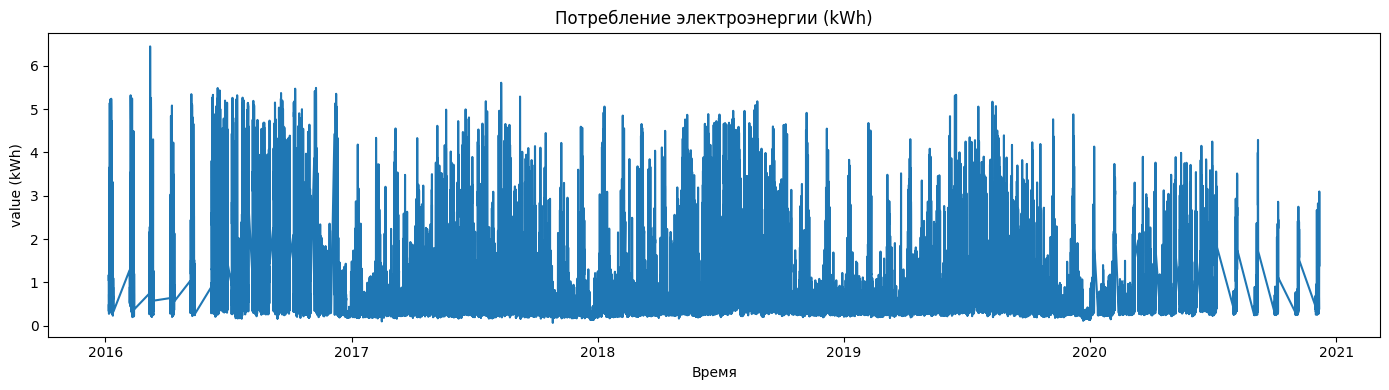

In [62]:
plt.figure(figsize=(14, 4))
plt.plot(df.index, df["value"])
plt.title("Потребление электроэнергии (kWh)")
plt.xlabel("Время")
plt.ylabel("value (kWh)")
plt.tight_layout()
plt.show()

## 3. Ручная генерация признаков (как в статье/ноутбуке + свои)

Ниже сделаны признаки из примеров:
- календарные (год/квартал/месяц/неделя/день/день недели/час)
- скользящие окна (mean/std/min/max, kurtosis, peaks)
- expanding window
- лаги
- разности

Плюс свои:
- sin/cos-кодирование циклических признаков
- EWM (экспоненциальное сглаживание)
- rolling z-score
- признак `is_weekend`

In [63]:
df_feat = df.copy()

df_feat["year"] = df_feat.index.year
df_feat["quarter"] = df_feat.index.quarter
df_feat["month"] = df_feat.index.month

df_feat["week"] = df_feat.index.isocalendar().week.astype(int)

df_feat["day"] = df_feat.index.day
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["hour"] = df_feat.index.hour
df_feat["is_weekend"] = (df_feat["dayofweek"] >= 5).astype(int)

df_feat.head()

,value,year,quarter,month,week,day,dayofweek,hour,is_weekend
StartDate,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,0,0
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,1,0
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,2,0
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,3,0
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,4,0


In [64]:
# подбор скользящих окон
windows = [3, 6, 12, 24, 168]

for w in windows:
    df_feat[f"roll_mean_{w}"] = df_feat["value"].rolling(w).mean()
    df_feat[f"roll_std_{w}"] = df_feat["value"].rolling(w).std()
    df_feat[f"roll_min_{w}"] = df_feat["value"].rolling(w).min()
    df_feat[f"roll_max_{w}"] = df_feat["value"].rolling(w).max()

# эксцесс в окне
df_feat["kurtosis_6"] = df_feat["value"].rolling(6).apply(lambda x: kurtosis(x, fisher=True))

# пики в окне
df_feat["peaks_6"] = df_feat["value"].rolling(6).apply(lambda x: len(find_peaks(x)[0]))

df_feat.head(10)

,value,year,quarter,month,week,day,dayofweek,hour,is_weekend,roll_mean_3,...,roll_mean_24,roll_std_24,roll_min_24,roll_max_24,roll_mean_168,roll_std_168,roll_min_168,roll_max_168,kurtosis_6,peaks_6
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,2,0,0.929333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,3,0,0.853000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,4,0,0.773333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,5,0,0.697667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.114059,2.0
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,6,0,0.575667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.291905,1.0
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,7,0,0.429333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.273392,1.0
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,8,0,0.426667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.371188,2.0


In [65]:
df_feat["expanding_mean_3"] = df_feat["value"].expanding(3).mean()

print("Финальное значение expanding окна:", round(df_feat["expanding_mean_3"].iloc[-1], 5))
print("Среднее по value:", round(df_feat["value"].mean(), 5))

Финальное значение expanding окна: 0.89163
Среднее по value: 0.89163


In [66]:
# лаговые признаки
lags = list(range(1, 25)) + [168]
for lag in lags:
    df_feat[f"lag_{lag}"] = df_feat["value"].shift(lag)

df_feat["lag_7_mean_7"] = df_feat["lag_7"].rolling(7).mean()

df_feat[["value", "lag_1", "lag_24", "lag_168"]].head(30)

,value,lag_1,lag_24,lag_168
StartDate,,,,
2016-01-06 00:00:00,1.057,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,1.057,NaN,NaN
2016-01-06 02:00:00,0.560,1.171,NaN,NaN
2016-01-06 03:00:00,0.828,0.560,NaN,NaN
2016-01-06 04:00:00,0.932,0.828,NaN,NaN
2016-01-06 05:00:00,0.333,0.932,NaN,NaN
2016-01-06 06:00:00,0.462,0.333,NaN,NaN
2016-01-06 07:00:00,0.493,0.462,NaN,NaN
2016-01-06 08:00:00,0.325,0.493,NaN,NaN


In [67]:
# разности
df_feat["diff_1"] = df_feat["value"].diff(1)
df_feat["diff_24"] = df_feat["value"].diff(24)
df_feat["pct_change_1"] = df_feat["value"].pct_change(1)
df_feat["pct_change_24"] = df_feat["value"].pct_change(24)

df_feat[["value", "diff_1", "diff_24", "pct_change_1"]].head(30)

,value,diff_1,diff_24,pct_change_1
StartDate,,,,
2016-01-06 00:00:00,1.057,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,0.114,NaN,0.107852
2016-01-06 02:00:00,0.560,-0.611,NaN,-0.521776
2016-01-06 03:00:00,0.828,0.268,NaN,0.478571
2016-01-06 04:00:00,0.932,0.104,NaN,0.125604
2016-01-06 05:00:00,0.333,-0.599,NaN,-0.642704
2016-01-06 06:00:00,0.462,0.129,NaN,0.387387
2016-01-06 07:00:00,0.493,0.031,NaN,0.067100
2016-01-06 08:00:00,0.325,-0.168,NaN,-0.340771


In [68]:
# кастомные признаки
# циклическое синусное/косинусное кодирование по часам и дням недели
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

df_feat["dow_sin"] = np.sin(2 * np.pi * df_feat["dayofweek"] / 7)
df_feat["dow_cos"] = np.cos(2 * np.pi * df_feat["dayofweek"] / 7)

# экспоненциальное сглаживание
df_feat["ewm_12"] = df_feat["value"].ewm(span=12, adjust=False).mean()
df_feat["ewm_24"] = df_feat["value"].ewm(span=24, adjust=False).mean()

# отклонение от суточной нормы (rolling z-score)
roll_mean_24 = df_feat["value"].rolling(24).mean()
roll_std_24 = df_feat["value"].rolling(24).std()
df_feat["zscore_24"] = (df_feat["value"] - roll_mean_24) / roll_std_24

df_feat.head()

,value,year,quarter,month,week,day,dayofweek,hour,is_weekend,roll_mean_3,...,diff_24,pct_change_1,pct_change_24,hour_sin,hour_cos,dow_sin,dow_cos,ewm_12,ewm_24,zscore_24
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,0,0,NaN,...,NaN,NaN,NaN,0.000000,1.000000,0.974928,-0.222521,1.057000,1.057000,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,1,0,NaN,...,NaN,0.107852,NaN,0.258819,0.965926,0.974928,-0.222521,1.074538,1.066120,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,2,0,0.929333,...,NaN,-0.521776,NaN,0.500000,0.866025,0.974928,-0.222521,0.995379,1.025630,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,3,0,0.853000,...,NaN,0.478571,NaN,0.707107,0.707107,0.974928,-0.222521,0.969628,1.009820,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,4,0,0.773333,...,NaN,0.125604,NaN,0.866025,0.500000,0.974928,-0.222521,0.963839,1.003594,NaN


## 4. Визуализация отдельных признаков

Требование задания: визуализировать часть признаков (линейные графики, гистограммы, scatter и т.д.).

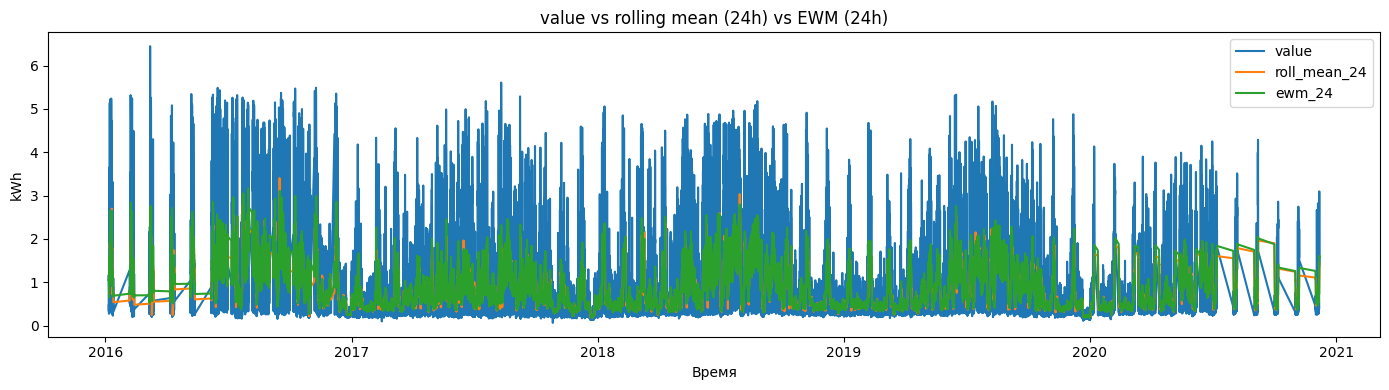

In [69]:
# визуализации: исходный ряд + rolling mean 24h + ewm 24
plt.figure(figsize=(14, 4))
plt.plot(df_feat.index, df_feat["value"], label="value")
plt.plot(df_feat.index, df_feat["roll_mean_24"], label="roll_mean_24")
plt.plot(df_feat.index, df_feat["ewm_24"], label="ewm_24")
plt.title("value vs rolling mean (24h) vs EWM (24h)")
plt.xlabel("Время")
plt.ylabel("kWh")
plt.legend()
plt.tight_layout()
plt.show()

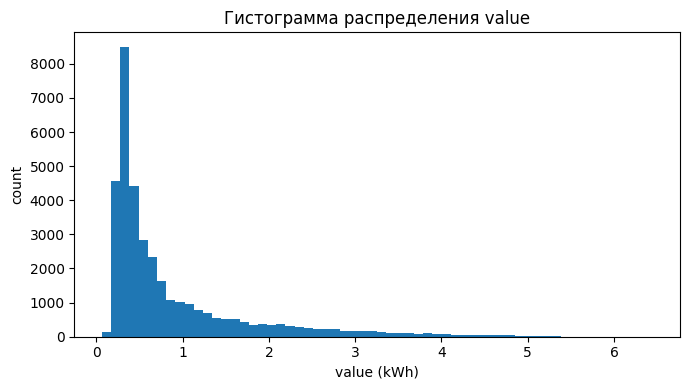

In [70]:
# распределение value
plt.figure(figsize=(7, 4))
plt.hist(df_feat["value"].dropna(), bins=60)
plt.title("Гистограмма распределения value")
plt.xlabel("value (kWh)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

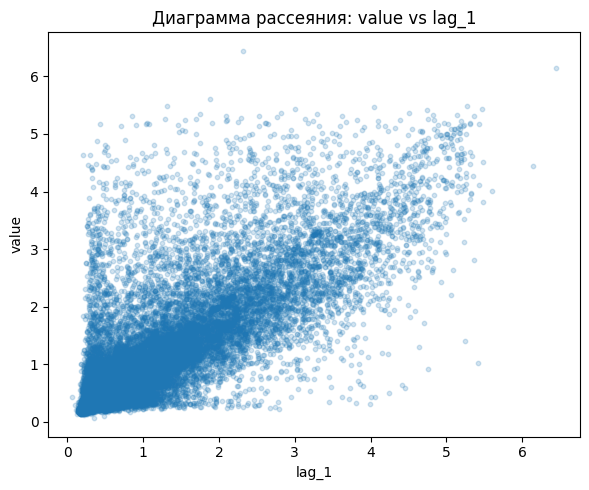

In [71]:
# диаграмма рассеяния: value vs lag_1
tmp = df_feat[["value", "lag_1"]].dropna()
plt.figure(figsize=(6, 5))
plt.scatter(tmp["lag_1"], tmp["value"], alpha=0.2, s=10)
plt.title("Диаграмма рассеяния: value vs lag_1")
plt.xlabel("lag_1")
plt.ylabel("value")
plt.tight_layout()
plt.show()

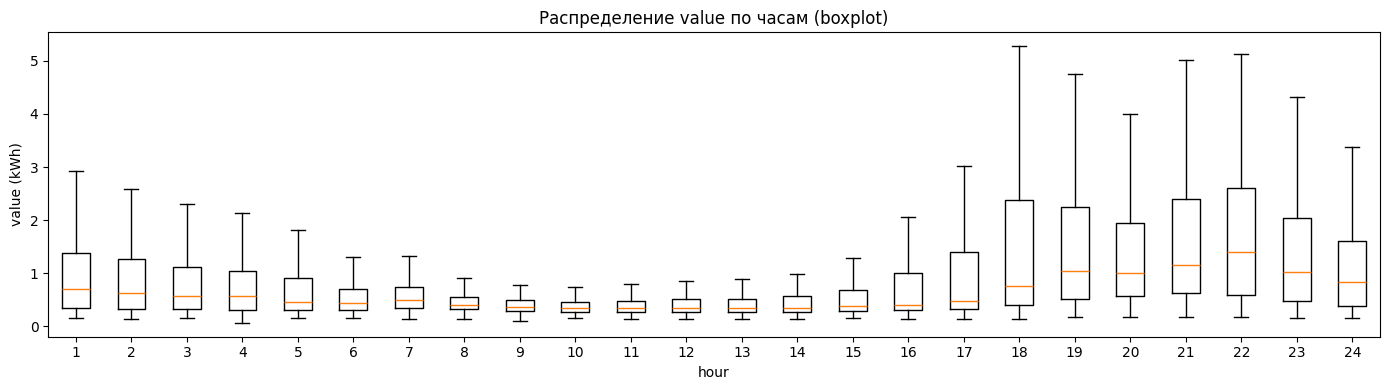

In [72]:
# распределение по часам суток, показывает суточную сезонность
data = [df_feat.loc[df_feat["hour"] == h, "value"].dropna().values for h in range(24)]

plt.figure(figsize=(14, 4))
plt.boxplot(data, showfliers=False)
plt.title("Распределение value по часам (boxplot)")
plt.xlabel("hour")
plt.ylabel("value (kWh)")
plt.tight_layout()
plt.show()

## 5. Автоматическая генерация признаков с помощью tsfresh (Quick start)

Чтобы признаки были информативными, будем извлекать их **по каждому дню**: один день = один объект (id), внутри дня время = час.

In [73]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

In [74]:
df_qs = df_feat[["value"]].copy().reset_index()
df_qs["date"] = df_qs["StartDate"].dt.date
df_qs["hour"] = df_qs["StartDate"].dt.hour

df_qs = df_qs.rename(columns={"date": "id", "hour": "time"})
df_qs = df_qs[["id", "time", "value"]]
df_qs.head()

,id,time,value
0,2016-01-06,0,1.057
1,2016-01-06,1,1.171
2,2016-01-06,2,0.560
3,2016-01-06,3,0.828
4,2016-01-06,4,0.932


In [75]:
# извлечение минимальных параметров
features_min = extract_features(
    df_qs,
    column_id="id",
    column_sort="time",
    column_value="value",
    default_fc_parameters=MinimalFCParameters(),
    n_jobs=0
)

impute(features_min)
features_min.head()

Feature Extraction: 100%|██████████| 1498/1498 [00:00<00:00, 6601.07it/s]


,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum
2016-01-06,29.691,0.6415,1.237125,24.0,1.104586,1.220109,1.658490,3.647,3.647,0.273
2016-01-07,43.177,1.4115,1.799042,24.0,1.356473,1.840018,2.253124,5.139,5.139,0.319
2016-01-08,50.057,1.3300,2.085708,24.0,1.629254,2.654469,2.646630,5.228,5.228,0.372
2016-01-09,47.363,1.1940,1.973458,24.0,1.625269,2.641500,2.556568,5.237,5.237,0.423
2016-01-10,42.203,1.2195,1.758458,24.0,1.540946,2.374515,2.338096,4.727,4.727,0.290


In [76]:
features_min.shape

(1498, 10)

In [77]:
# извлечение эффективных параметров
features_eff = extract_features(
    df_qs,
    column_id="id",
    column_sort="time",
    column_value="value",
    default_fc_parameters=EfficientFCParameters(),
    n_jobs=0
)

impute(features_eff)
features_eff.head()

Feature Extraction: 100%|██████████| 1498/1498 [00:55<00:00, 26.83it/s]
/Users/andrew/vscode_projects/time_series_malyshevam_shad311/venv/lib/python3.13/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__fft_coefficient__attr_"real"__coeff_13'
 'value__fft_coefficient__attr_"real"__coeff_14'
 'value__fft_coefficient__attr_"real"__coeff_15'
 'value__fft_coefficient__attr_"real"__coeff_16'
 'value__fft_coefficient__attr_"real"__coeff_17'
 'value__fft_coefficient__attr_"real"__coeff_18'
 'value__fft_coefficient__attr_"real"__coeff_19'
 'value__fft_coefficient__attr_"real"__coeff_20'
 'value__fft_coefficient__attr_"real"__coeff_21'
 'value__fft_coefficient__attr_"real"__coeff_22'
 'value__fft_coefficient__attr_"real"__coeff_23'
 'value__fft_coefficient__attr_"real"__coeff_24'
 'value__fft_coefficient__attr_"real"__coeff_25'
 'value__fft_coefficient__attr_"real"__coeff_26'
 'value__fft_coefficient__attr_"real"__coeff_27'
 'value__fft_coefficient

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
2016-01-06,1.0,0.0,0.0,0.0,29.691,66.014105,0.441783,0.032043,-0.029864,0.6415,...,0.535961,1.031767,2.098147,1.708708,2.507675,2.666149,2.770974,2.890372,0.0,2.846714
2016-01-07,1.0,0.0,0.0,0.0,43.177,121.837655,0.575826,0.019565,-0.014909,1.4115,...,0.937156,0.937156,1.732659,1.516522,2.120326,2.388890,2.579625,2.736339,0.0,3.599857
2016-01-08,1.0,0.0,0.0,0.0,50.057,168.111555,0.547087,0.011174,-0.016750,1.3300,...,0.535961,0.937156,1.945935,1.641230,2.532591,2.995732,2.944439,2.890372,0.0,4.410429
2016-01-09,1.0,0.0,0.0,0.0,47.363,156.864905,0.562391,0.061696,-0.025045,1.1940,...,0.535961,0.793730,1.839297,1.618765,2.466577,2.857103,2.871476,2.890372,0.0,4.321857
2016-01-10,1.0,0.0,0.0,0.0,42.203,131.200579,0.580087,0.002261,-0.022091,1.2195,...,0.830518,0.937156,2.031759,1.641230,2.466577,2.926418,2.944439,2.890372,0.0,3.910000


In [78]:
features_eff.shape

(1498, 777)

In [79]:
# вывод топ-15 признаков по дисперсии
variances = features_eff.var().sort_values(ascending=False)
variances.head(15)

value__friedrich_coefficients__coeff_1__m_3__r_30    1.026762e+12
value__friedrich_coefficients__coeff_0__m_3__r_30    7.376517e+11
value__friedrich_coefficients__coeff_2__m_3__r_30    1.587984e+11
value__friedrich_coefficients__coeff_3__m_3__r_30    2.728867e+09
value__fft_coefficient__attr_"angle"__coeff_3        1.440533e+04
value__fft_coefficient__attr_"angle"__coeff_5        1.294616e+04
value__fft_coefficient__attr_"angle"__coeff_6        1.235543e+04
value__fft_coefficient__attr_"angle"__coeff_2        1.234801e+04
value__fft_coefficient__attr_"angle"__coeff_10       1.220298e+04
value__fft_coefficient__attr_"angle"__coeff_9        1.177068e+04
value__fft_coefficient__attr_"angle"__coeff_4        1.064564e+04
value__fft_coefficient__attr_"angle"__coeff_11       1.038681e+04
value__fft_coefficient__attr_"angle"__coeff_12       8.101712e+03
value__fft_coefficient__attr_"angle"__coeff_7        7.840587e+03
value__fft_coefficient__attr_"angle"__coeff_8        7.772668e+03
dtype: flo

## 6. Исследование асимметрии и эксцесса (skewness & excess)

- **Асимметрия** (skewness) показывает скошенность распределения.
- **Эксцесс** (excess, kurtosis Fisher) показывает «островершинность» и тяжесть хвостов.

Ниже считаем для всего ряда и дополнительно по месяцам (как мини-исследование).

In [80]:
series = df_feat["value"].dropna()

sk_total = float(skew(series))
ex_total = float(kurtosis(series, fisher=True))  # fisher=True -> эксцесс (kurtosis - 3)

print(f"Асимметрия (skewness) всего ряда: {sk_total:.4f}")
print(f"Эксцесс (excess) всего ряда:      {ex_total:.4f}")

Асимметрия (skewness) всего ряда: 2.1284
Эксцесс (excess) всего ряда:      4.5325


In [81]:
# статы месяцам: сравнение асимметрии и эксцесса
tmp = df_feat[["value", "month"]].dropna()
month_stats = tmp.groupby("month")["value"].agg(
    skewness=lambda x: skew(x),
    excess=lambda x: kurtosis(x, fisher=True),
    mean="mean",
    std="std",
    count="count"
).reset_index()

month_stats

,month,skewness,excess,mean,std,count
0,1,3.663797,16.040422,0.637175,0.655507,3024
1,2,3.266754,12.456617,0.657002,0.687052,2760
2,3,3.079863,11.371912,0.682475,0.721211,3024
3,4,2.471427,7.099477,0.730380,0.692967,2928
4,5,1.843267,3.352799,0.952676,0.888348,3024
5,6,1.418744,1.428065,1.220692,1.105897,3360
6,7,1.304468,0.968868,1.262857,1.132166,3024
7,8,1.236309,0.812133,1.318578,1.101353,3000
8,9,1.539365,2.007768,1.133567,1.009453,2904
9,10,2.545915,7.218391,0.797658,0.816743,3000


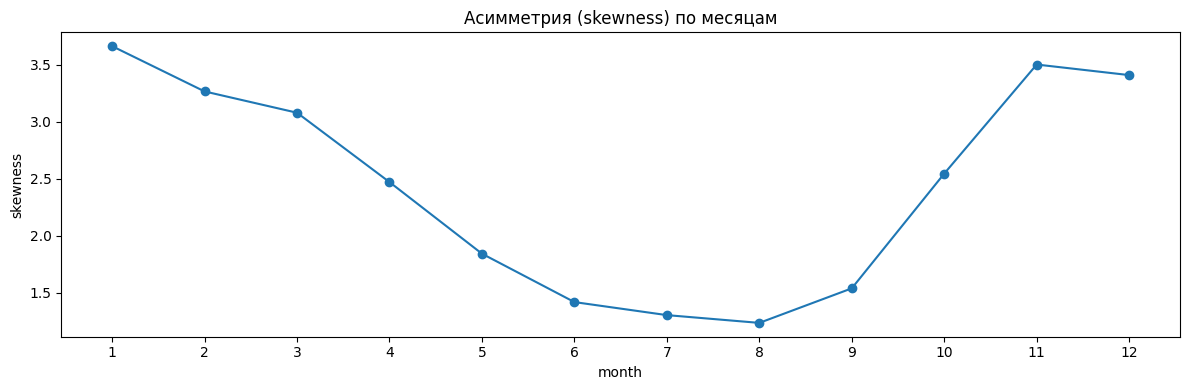

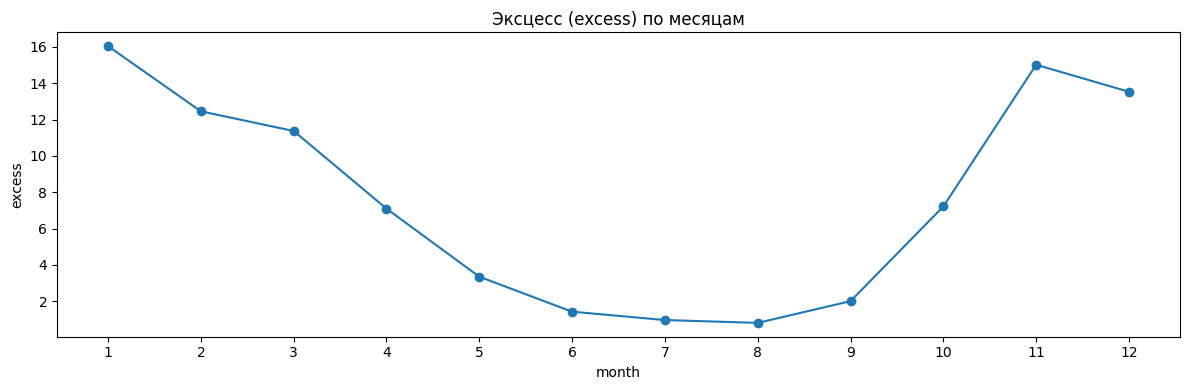

In [82]:
plt.figure(figsize=(12, 4))
plt.plot(month_stats["month"], month_stats["skewness"], marker="o")
plt.title("Асимметрия (skewness) по месяцам")
plt.xlabel("month")
plt.ylabel("skewness")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(month_stats["month"], month_stats["excess"], marker="o")
plt.title("Эксцесс (excess) по месяцам")
plt.xlabel("month")
plt.ylabel("excess")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

## 7. Итоговые выводы (тезисно, как в прошлых ЛР)

- Загружен датасет `power_usage_2016_to_2020.csv`, временная колонка `StartDate` приведена к `datetime` и использована как индекс.
- Выполнен первичный анализ: проверены диапазон дат, пропуски и корректность временного индекса.
- Реализована **ручная генерация признаков** по примеру статьи/ноутбука: календарные признаки, лаги, скользящие окна (mean/std/min/max), expanding mean, разности, rolling-kurtosis и rolling-peaks.
- Дополнительно реализованы **собственные признаки**: циклическое кодирование sin/cos для часа и дня недели, экспоненциальное сглаживание (EWM), rolling z-score и признак выходного дня.
- Для отдельных признаков выполнена визуализация: линейные графики (value vs rolling/ewm), гистограмма распределения, scatter (value vs lag_1), boxplot по часам.
- Применен **Quick start подход библиотеки tsfresh**: данные приведены к формату (id, time, value), признаки извлечены (MinimalFCParameters и EfficientFCParameters), получены матрицы признаков по каждому дню.
- Исследованы характеристики распределения `value`: вычислены **асимметрия** и **эксцесс** для всего ряда и по месяцам, выполнена визуализация их изменений по сезонам.
